# 1. Introduction

# 2. Import Libraries

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, SimpleRNN
from tensorflow.keras.models import Sequential


nltk.download('stopwords')
nltk.download('punkt')

import pickle

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#--------------------------------------
# For load data in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Data Loading

In [3]:
# Data Loading
df_ori = pd.read_csv('/content/drive/MyDrive/review_dana_labelled.csv')

# Variabel untuk dataset
df = df_ori.copy()

# Show top 5 data
df.head()

,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,Bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,Dana mmg keren mantap.,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  50000 non-null  object
 1   score     50000 non-null  int64 
 2   at        50000 non-null  object
 3   content   50000 non-null  object
 4   sentimen  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [5]:
# Check missing value
df.isna().sum()

userName    0
score       0
at          0
content     0
sentimen    0
dtype: int64

In [6]:
# Check data duplicate
df.duplicated().sum()

0

## 3.1 Drop Unused Column

In [7]:
# Drop Unused Columns
df = df.drop(['userName','at','score'],axis=1)

# Check data
df.head()

,content,sentimen
0,Bagus,POSITIVE
1,Dana mmg keren mantap.,POSITIVE
2,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


## 3.2 Filter Data

In [8]:
# Filter 3000 Data
class_A = df[df['sentimen'] == 'POSITIVE']
class_B = df[df['sentimen'] == 'NEGATIVE']
class_C = df[df['sentimen'] == 'NEUTRAL']

# Sample data per class
total_per_class = 3000 // 3

# Filter sample data per class
class_A_sample = class_A.sample(n=total_per_class)
class_B_sample = class_B.sample(n=total_per_class)
class_C_sample = class_C.sample(n=total_per_class)

# Concat data per class
df = pd.concat([class_A_sample, class_B_sample, class_C_sample])

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 33855 to 27588
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   3000 non-null   object
 1   sentimen  3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB


# 4. EDA

## 4.1 Sentiment

In [9]:
# Check Distribution of Dataset
df.sentimen.value_counts()

sentimen
POSITIVE    1000
NEGATIVE    1000
NEUTRAL     1000
Name: count, dtype: int64

In [10]:
target = df['sentimen'].value_counts().to_frame(name='count')
target['percentage'] = df['sentimen'].value_counts(normalize=True)
target.reset_index(inplace=True)
target

,sentimen,count,percentage
0,POSITIVE,1000,0.333333
1,NEGATIVE,1000,0.333333
2,NEUTRAL,1000,0.333333


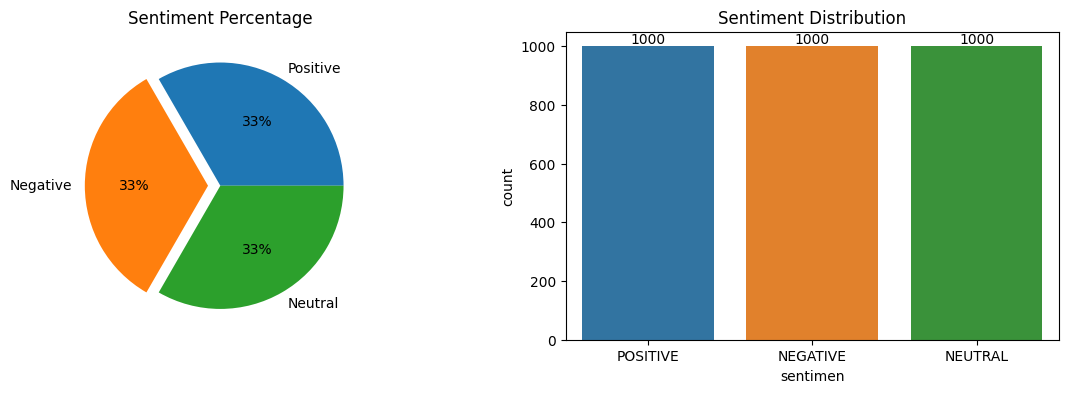

In [11]:
# Visualization
plt.figure(figsize=(14, 4))

# Pie Chart
plt.subplot(1,2,1)
plt.title('Sentiment Percentage')
explode = [0,0.1,0]
labels = ['Positive','Negative', 'Neutral']
plt.pie(target["percentage"], labels=labels,explode=explode, autopct='%.0f%%')

# Barplot
plt.subplot(1,2,2)
plt.title('Sentiment Distribution')
ax = sns.countplot(data=df, x='sentimen', hue='sentimen')
for i in ax.containers:
    ax.bar_label(i,)

plt.show()

## 4.2 Sentiment Characteristics

## 4.2.1 Positive

In [12]:
# Show Sentiment Positive
df[df['sentimen']=='POSITIVE']

,content,sentimen
33855,cepat dan aman,POSITIVE
44037,sangat bagus dan lancar dlm segalanya,POSITIVE
32204,pelayanan cepat,POSITIVE
7614,Sangat baik,POSITIVE
48123,baik,POSITIVE
...,...,...
42144,MantAaap,POSITIVE
47438,Bermanfaat,POSITIVE
42243,mantap,POSITIVE
717,👍👍,POSITIVE


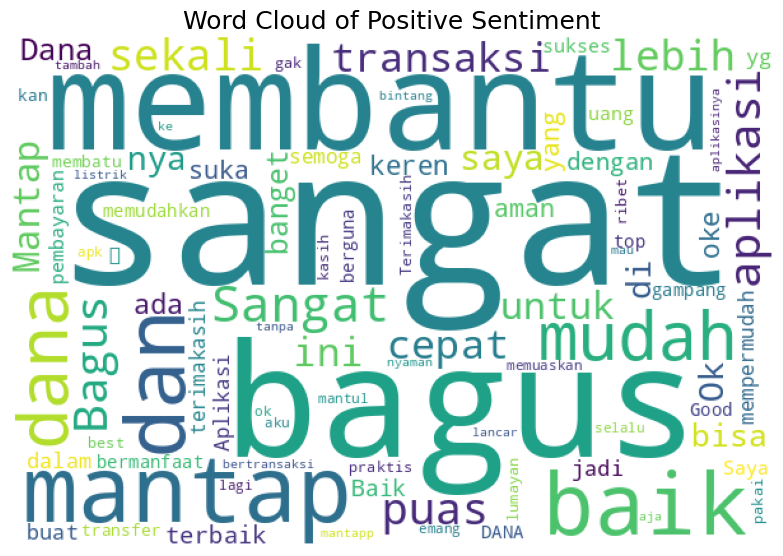

In [13]:
# Filter kalimat dengan sentimen positif
positive_tweets = df[df['sentimen'] == 'POSITIVE']['content']

# Menghitung frekuensi kata
word_counts = Counter()
for tweet in positive_tweets:
    words = tweet.split()
    word_counts.update(words)

# Mengurutkan kata berdasarkan frekuensi
most_common_words = word_counts.most_common()

# Membuat word cloud
wordcloud = WordCloud(width = 600, height = 400, background_color = 'white', min_font_size = 10).generate_from_frequencies(dict(most_common_words))
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Positive Sentiment', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## 4.2.2 Neutral

In [14]:
# Show Sentiment Neutral
df[df['sentimen']=='NEUTRAL']

,content,sentimen
16665,JANGAN DOWNLOAD dana lagi masa bisa bayar yout...,NEUTRAL
16928,"simpel dan mudah di gunakan, hanya saja fitur ...",NEUTRAL
38597,Poko'e Top Markotop,NEUTRAL
27238,alhmdulh ada apk dana jd gampang transfer.mksh,NEUTRAL
42732,sudah transfer ke penerima tpi saldo tidak ber...,NEUTRAL
...,...,...
19247,taser taser taserr,NEUTRAL
48735,praktisberguna untukkebutuhan transaction JDI ...,NEUTRAL
28597,Dana teman gua sering di bobol tingkatkan ke a...,NEUTRAL
37524,Tidak bisa d intsall cuman muter di situ2 aja,NEUTRAL


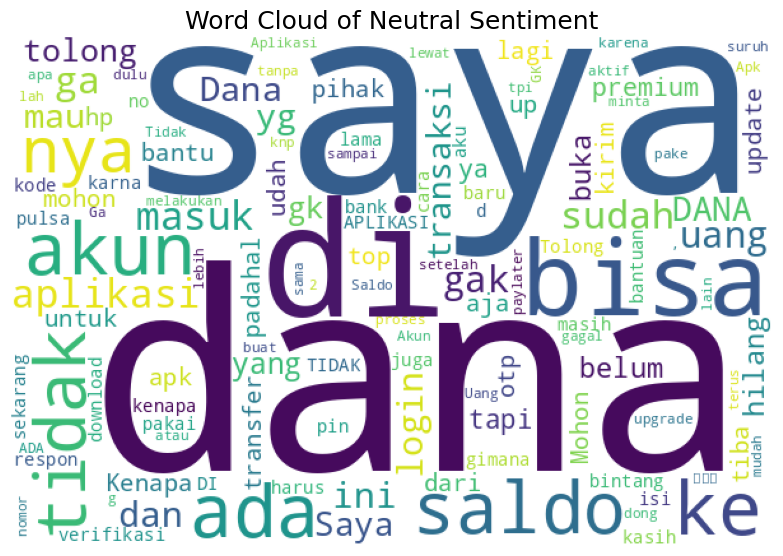

In [15]:
# Filter kalimat dengan sentimen neutral
positive_tweets = df[df['sentimen'] == 'NEUTRAL']['content']

# Menghitung frekuensi kata
word_counts = Counter()
for tweet in positive_tweets:
    words = tweet.split()
    word_counts.update(words)

# Mengurutkan kata berdasarkan frekuensi
most_common_words = word_counts.most_common()

# Membuat word cloud
wordcloud = WordCloud(width = 600, height = 400, background_color = 'white', min_font_size = 10).generate_from_frequencies(dict(most_common_words))
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Neutral Sentiment', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## 4.2.3 Negative

In [16]:
# Show Sentiment NEGATIVE
df[df['sentimen']=='NEGATIVE']

,content,sentimen
11972,saya kok gak bisa login ya ka,NEGATIVE
20219,Mohon maaf sudah beberapa hari eror tidak bisa...,NEGATIVE
21648,good job,NEGATIVE
21540,Susah upgarde ke premium padahal sudah mengiku...,NEGATIVE
26043,Gak bisa buat akun... Bintang 1 mending pake a...,NEGATIVE
...,...,...
35813,wow nusa188,NEGATIVE
2345,"Tolong aplikasi ini segera di tutup,aplikasi i...",NEGATIVE
19685,"Maaf ini kenapa yaa saya tidak bisa login,diup...",NEGATIVE
14330,ok,NEGATIVE


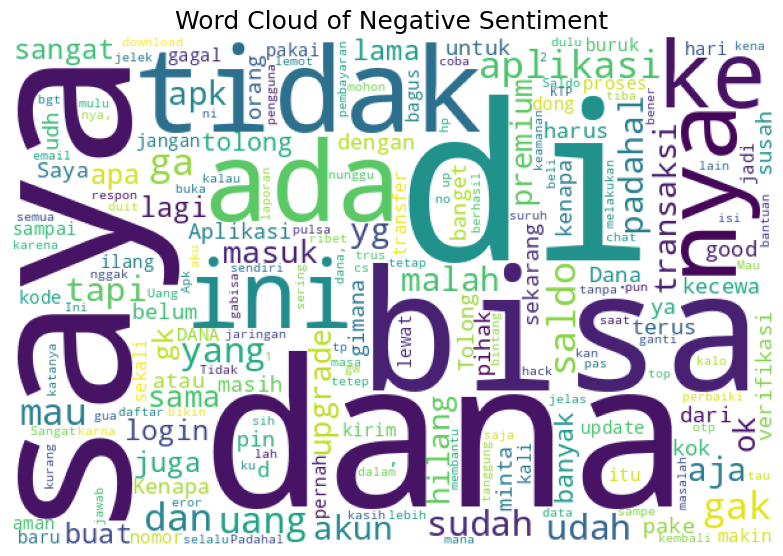

In [17]:
# Filter kalimat dengan sentimen negatif
positive_tweets = df[df['sentimen'] == 'NEGATIVE']['content']

# Menghitung frekuensi kata
word_counts = Counter()
for tweet in positive_tweets:
    words = tweet.split()
    word_counts.update(words)

# Mengurutkan kata berdasarkan frekuensi
most_common_words = word_counts.most_common()

# Membuat word cloud
wordcloud = WordCloud(width = 600, height = 400, background_color = 'white', min_font_size = 10).generate_from_frequencies(dict(most_common_words))
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Negative Sentiment', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

# 5. Feature Engineering

## 5.1 Text Preprocessing

In [18]:
# Define Stopwords
from nltk.corpus import stopwords
stpwds_id = list(set(stopwords.words('indonesian')))
new_word = ['ko','gk','yg','bos','buat','ya','ga','ini','juga',
            'sangat','buat','tanpa','lebih','pakai','bagi','apk',
            'terima kasih','masokkkkk','nya','gak','dana','aplikasi']
stpwds_id.extend(new_word)

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

In [19]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Symbol removal
  text = re.sub("^!-.ðŸ‘¡,âœŒï˜£ð˜¨ð˜¶Â²?/¢+™'", " ", text)

  # Symbol removal
  text = re.sub("!-.ðŸ‘¡,âœŒï˜£ð˜¨ð˜¶Â²?/¢+™'\s*$", " ", text)

  # Number Removal
  text = re.sub(r"[0-9]", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [20]:
# Applying Text Preprocessing to the Dataset
df['review'] = df['content'].apply(lambda x: text_preprocessing(x))
df

,content,sentimen,review
33855,cepat dan aman,POSITIVE,cepat aman
44037,sangat bagus dan lancar dlm segalanya,POSITIVE,bagus lancar dlm
32204,pelayanan cepat,POSITIVE,layan cepat
7614,Sangat baik,POSITIVE,
48123,baik,POSITIVE,
...,...,...,...
19247,taser taser taserr,NEUTRAL,taser taser taserr
48735,praktisberguna untukkebutuhan transaction JDI ...,NEUTRAL,praktisberguna untukkebutuhan transaction jdi ...
28597,Dana teman gua sering di bobol tingkatkan ke a...,NEUTRAL,teman gua bobol tingkat aman cepat harap respo...
37524,Tidak bisa d intsall cuman muter di situ2 aja,NEUTRAL,d intsall cuman muter situ aja


## 5.2 Target Conversion

In [21]:
# Display Target
df.sentimen.unique()

array(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], dtype=object)

In [22]:
# Change Target into Number
df['label'] = df['sentimen'].replace({'NEGATIVE' : 0, 'NEUTRAL' : 1, 'POSITIVE' : 2})
df

,content,sentimen,review,label
33855,cepat dan aman,POSITIVE,cepat aman,2
44037,sangat bagus dan lancar dlm segalanya,POSITIVE,bagus lancar dlm,2
32204,pelayanan cepat,POSITIVE,layan cepat,2
7614,Sangat baik,POSITIVE,,2
48123,baik,POSITIVE,,2
...,...,...,...,...
19247,taser taser taserr,NEUTRAL,taser taser taserr,1
48735,praktisberguna untukkebutuhan transaction JDI ...,NEUTRAL,praktisberguna untukkebutuhan transaction jdi ...,1
28597,Dana teman gua sering di bobol tingkatkan ke a...,NEUTRAL,teman gua bobol tingkat aman cepat harap respo...,1
37524,Tidak bisa d intsall cuman muter di situ2 aja,NEUTRAL,d intsall cuman muter situ aja,1


## 5.3 Split Feature, Target, Train and Test Set

For this task, we only need column `CONTENT` as corpus and column `CLASS` as target.

In [23]:
# Splitting Dataset

X_train, X_test, y_train, y_test = train_test_split(df['review'],
                                                    df.label,
                                                    test_size=0.2,
                                                    random_state=6,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train)

print('Train Size : ', len(X_train))
print('Val Size   : ', len(X_val))
print('Test Size  : ', len(X_test))

Train Size :  2160
Val Size   :  240
Test Size  :  600


## 5.4 Feature Encoding

In [24]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

# 6. ANN Training

## 6.1 Model Building

### 6.1.1 - Text Vectorization

In [25]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<2160x2349 sparse matrix of type '<class 'numpy.int64'>'
	with 10461 stored elements in Compressed Sparse Row format>

In [26]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  2349
Maximum Sentence Length :  81 tokens


In [27]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [28]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'saldo',
 'uang',
 'bantu',
 'akun',
 'bagus',
 'transaksi',
 'masuk',
 'tolong',
 'udah',
 'hilang',
 'login',
 'premium',
 'mantap',
 'aja',
 'mudah',
 'aman',
 'buka',
 'ok']

### 6.1.2 - Word Embedding

In [29]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

### 6.1.3 - LSTM

In [30]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

CPU times: user 1.1 s, sys: 49 ms, total: 1.15 s
Wall time: 1.59 s


In [31]:
%%time
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 19s 123ms/step - loss: 1.0058 - accuracy: 0.4880 - val_loss: 0.7946 - val_accuracy: 0.5667
Epoch 2/25
68/68 [==============================] - 4s 62ms/step - loss: 0.7180 - accuracy: 0.6486 - val_loss: 0.6196 - val_accuracy: 0.7042
Epoch 3/25
68/68 [==============================] - 3s 42ms/step - loss: 0.5209 - accuracy: 0.7838 - val_loss: 0.5597 - val_accuracy: 0.7750
Epoch 4/25
68/68 [==============================] - 2s 28ms/step - loss: 0.3680 - accuracy: 0.8690 - val_loss: 0.5830 - val_accuracy: 0.7833
Epoch 5/25
68/68 [==============================] - 1s 22ms/step - loss: 0.2976 - accuracy: 0.8972 - val_loss: 0.6327 - val_accuracy: 0.7500
Epoch 6/25
68/68 [==============================] - 3s 38ms/step - loss: 0.2389 - accuracy: 0.9139 - val_loss: 0.7272 - val_accuracy: 0.7625
Epoch 7/25
68/68 [==============================] - 2s 33ms/step - loss: 0.2195 - accuracy: 0.9213 - val_loss: 0.7127 - val_accuracy: 0.7708
Epoch 8/25


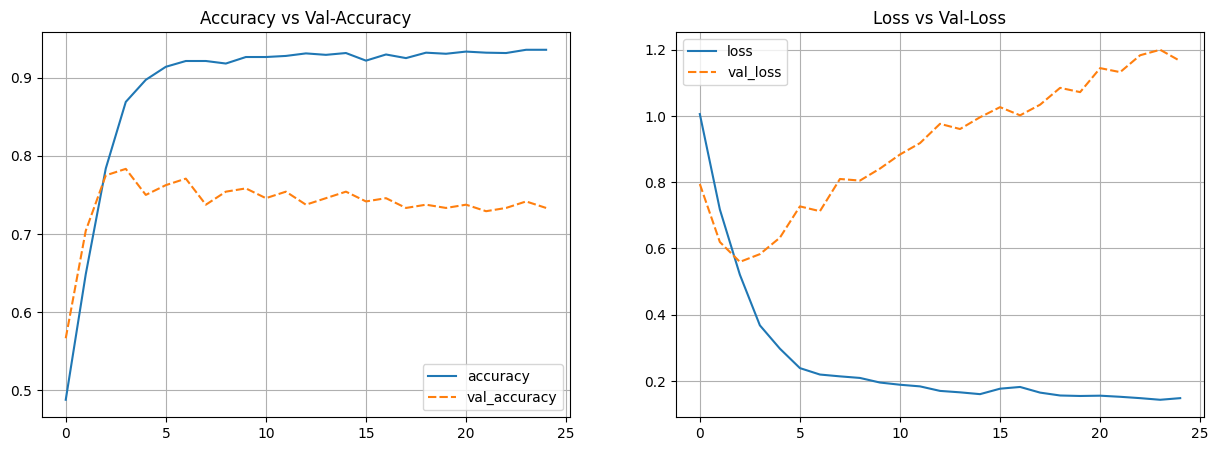

In [32]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [33]:
y_test.unique()

array([0, 2, 1])

In [34]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_lstm_1.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.72      0.53      0.61       200
           1       0.56      0.69      0.62       200
           2       0.80      0.82      0.81       200

    accuracy                           0.68       600
   macro avg       0.69      0.68      0.68       600
weighted avg       0.69      0.68      0.68       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.

### 6.1.3 - GRU

In [35]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_gru = Sequential()
model_gru.add(text_vectorization)
model_gru.add(embedding)
model_gru.add(Bidirectional(GRU(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.1))
model_gru.add(Bidirectional(GRU(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(3, activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics='accuracy')

CPU times: user 941 ms, sys: 12 ms, total: 953 ms
Wall time: 943 ms


In [36]:
%%time
model_gru_hist = model_gru.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 20s 151ms/step - loss: 0.7193 - accuracy: 0.7787 - val_loss: 0.5936 - val_accuracy: 0.7500
Epoch 2/25
68/68 [==============================] - 5s 72ms/step - loss: 0.2587 - accuracy: 0.9079 - val_loss: 0.7259 - val_accuracy: 0.7583
Epoch 3/25
68/68 [==============================] - 3s 49ms/step - loss: 0.1929 - accuracy: 0.9255 - val_loss: 0.7918 - val_accuracy: 0.7500
Epoch 4/25
68/68 [==============================] - 2s 35ms/step - loss: 0.1795 - accuracy: 0.9264 - val_loss: 0.8415 - val_accuracy: 0.7542
Epoch 5/25
68/68 [==============================] - 2s 35ms/step - loss: 0.1734 - accuracy: 0.9282 - val_loss: 0.8402 - val_accuracy: 0.7417
Epoch 6/25
68/68 [==============================] - 2s 34ms/step - loss: 0.1592 - accuracy: 0.9301 - val_loss: 0.9141 - val_accuracy: 0.7667
Epoch 7/25
68/68 [==============================] - 2s 30ms/step - loss: 0.1618 - accuracy: 0.9273 - val_loss: 0.9266 - val_accuracy: 0.7542
Epoch 8/25


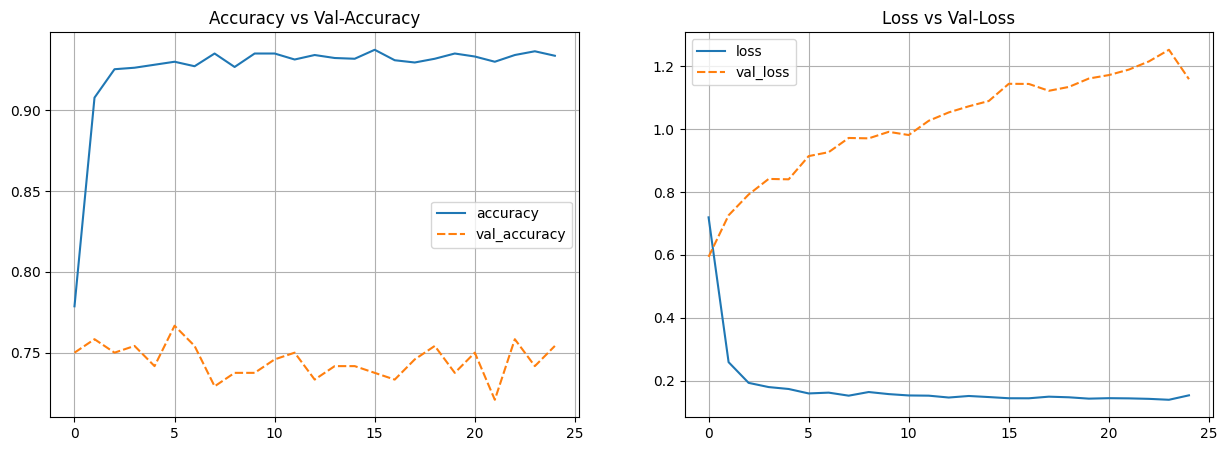

In [37]:
# Plot Training Results

model_gru_hist_df = pd.DataFrame(model_gru_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [38]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_gru.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       200
           1       0.55      0.54      0.54       200
           2       0.80      0.83      0.82       200

    accuracy                           0.66       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.

### 6.1.3 - RNN

In [39]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_rnn = Sequential()
model_rnn.add(text_vectorization)
model_rnn.add(embedding)
model_rnn.add(SimpleRNN(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_rnn.add(Dropout(0.1))
model_rnn.add(SimpleRNN(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(3, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='AdaMax', metrics='accuracy')

CPU times: user 245 ms, sys: 6.95 ms, total: 252 ms
Wall time: 248 ms


In [40]:
%%time
model_rnn_hist = model_rnn.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 19s 242ms/step - loss: 0.6837 - accuracy: 0.6778 - val_loss: 0.6873 - val_accuracy: 0.7375
Epoch 2/25
68/68 [==============================] - 13s 180ms/step - loss: 0.5580 - accuracy: 0.8005 - val_loss: 0.7442 - val_accuracy: 0.6917
Epoch 3/25
68/68 [==============================] - 11s 160ms/step - loss: 0.4193 - accuracy: 0.8667 - val_loss: 0.7408 - val_accuracy: 0.7458
Epoch 4/25
68/68 [==============================] - 12s 180ms/step - loss: 0.3581 - accuracy: 0.8921 - val_loss: 0.7752 - val_accuracy: 0.7375
Epoch 5/25
68/68 [==============================] - 11s 164ms/step - loss: 0.3046 - accuracy: 0.9009 - val_loss: 0.7700 - val_accuracy: 0.7292
Epoch 6/25
68/68 [==============================] - 12s 170ms/step - loss: 0.2587 - accuracy: 0.9120 - val_loss: 0.8146 - val_accuracy: 0.7292
Epoch 7/25
68/68 [==============================] - 12s 170ms/step - loss: 0.2822 - accuracy: 0.9046 - val_loss: 0.9399 - val_accuracy: 0.7042

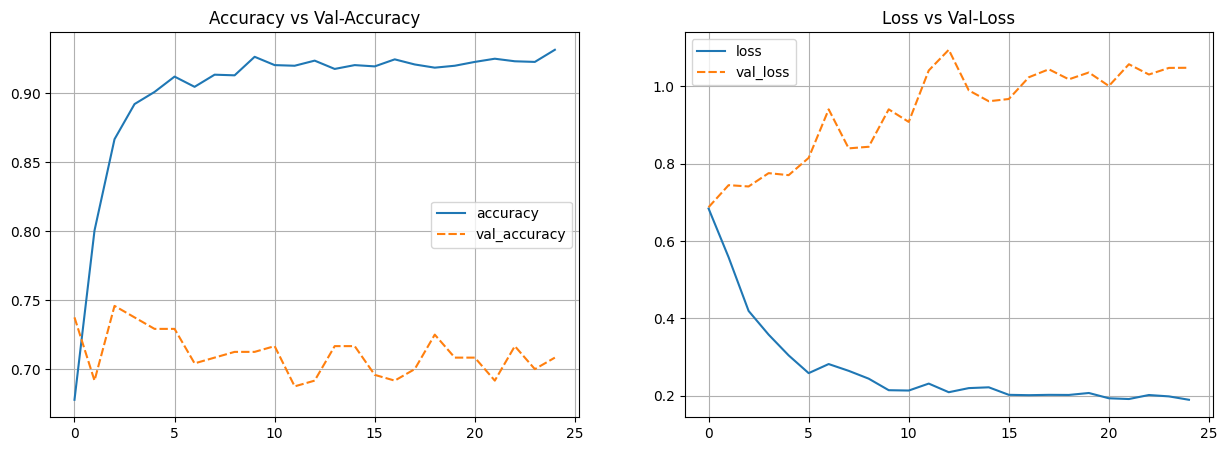

In [41]:
# Plot Training Results

model_rnn_hist_df = pd.DataFrame(model_rnn_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_rnn_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_rnn_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [42]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_rnn.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59       200
           1       0.62      0.56      0.59       200
           2       0.71      0.92      0.80       200

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.66       600
weighted avg       0.67      0.67      0.66       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.

### 6.1.4 - LSTM with Transfer Learning

Let's improve our model using transfer learning. We will use embedding layer that was trained on Google news 3B corpus.

For more details please visit :
* [Embedding layer source](https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1)
* [List of Embedding Layers in Indonesian language](https://tfhub.dev/s?module-type=text-embedding&q=indonesian)

In [43]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [44]:
# Model Training using LSTM with Transfer Learning
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(3, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 10s 44ms/step - loss: 1.0775 - accuracy: 0.4176 - val_loss: 1.0083 - val_accuracy: 0.4958
Epoch 2/25
68/68 [==============================] - 1s 21ms/step - loss: 0.9658 - accuracy: 0.5111 - val_loss: 0.9169 - val_accuracy: 0.5208
Epoch 3/25
68/68 [==============================] - 2s 24ms/step - loss: 0.9550 - accuracy: 0.5273 - val_loss: 0.9234 - val_accuracy: 0.5083
Epoch 4/25
68/68 [==============================] - 2s 30ms/step - loss: 0.9450 - accuracy: 0.5116 - val_loss: 0.8783 - val_accuracy: 0.5250
Epoch 5/25
68/68 [==============================] - 2s 24ms/step - loss: 0.9408 - accuracy: 0.5259 - val_loss: 0.8933 - val_accuracy: 0.5667
Epoch 6/25
68/68 [==============================] - 1s 21ms/step - loss: 0.9220 - accuracy: 0.5380 - val_loss: 0.8595 - val_accuracy: 0.5625
Epoch 7/25
68/68 [==============================] - 1s 21ms/step - loss: 0.9305 - accuracy: 0.5370 - val_loss: 0.8891 - val_accuracy: 0.5542
Epoch 8/25
6

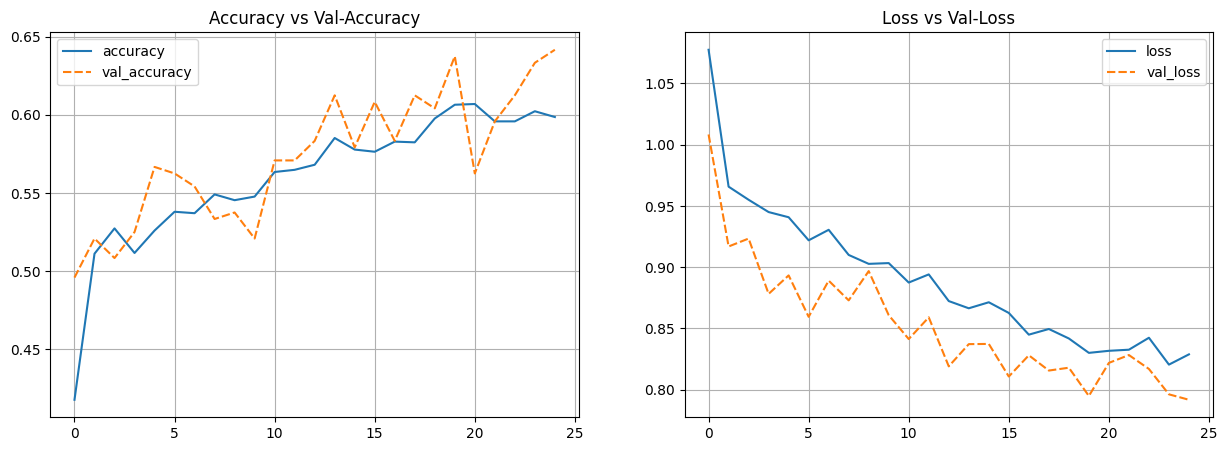

In [45]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [46]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_lstm_2.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.60      0.54      0.57       200
           1       0.50      0.46      0.48       200
           2       0.65      0.78      0.71       200

    accuracy                           0.59       600
   macro avg       0.58      0.59      0.58       600
weighted avg       0.58      0.59      0.58       600



# 7 Model Analysis

Setelah dilakukan percobaan menggunakan beberapa model, model LSTM yang menghasilkan hasil terbaik. Sehingga model LSTM yang akan kita simpan untuk model inference.

# 8. Model Saving

In [48]:
# Freeze model
model_lstm_1.trainable = False

# Save Model
model_lstm_1.save('model_lstm_1', save_format='tf')

#TEXT PREPROCESSING
with open('text_preprocessing.pkl', 'wb') as file_2:
    pickle.dump(text_preprocessing, file_2)